# Generate stratified panels by week, machine using preprocessed domains data: Using census data

Multiple panels are generated for each week of data by using a random stratified sampling process.

The preprocessed sessions/domains data is used so that panels only include samples with sufficient data.

Panels are sampled using stratified random sampling (without replacement) so that the distribution of income x race demographics in each of the panels matches the distribution of the U.S. population, as reported by the Census (CPS).

Strata are defined by their income x race (`income,race`) categories.

### CPS data

From 2017 estimates from Table HINC-04. https://www.census.gov/data/tables/time-series/demo/income-poverty/cps-hinc/hinc-04.2017.html

In [7]:
from datetime import datetime
import random
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils.data import income_groups_4

### Income group mapping

Comscore data is coded with 8 income groups.

CPS data is coded with many more.

We create a mapping to 4 income groups that is consistent for the data sources:

- less than \$25,000
- \$25,000 - \\$75,000
- \$75,000 - \\$150,000
- \$150,000 or more

In [10]:
comscore_income_codes = pd.DataFrame([
    [11, 'Less than $25,000'],
    [12, '\$25,000 – \$39,999'],
    [13, '\$40,000 – $59,999'],
    [14, '\$60,000 – $74,999'],
    [15, '\$75,000 – $99,999'],
    [16, '\$100,000 to $149,999'],
    [17, '\$150,000 to $199,999'],
    [18, '\$200,000 or more'],
    
], columns=['comscore_code', 'comscore_description'])
comscore_income_codes['collapsed_code'] = [1,2,2,2,3,3,4,4]
comscore_income_codes['collapsed_description'] = comscore_income_codes['collapsed_code'].map(
    income_groups_4
)
comscore_income_codes

,comscore_code,comscore_description,collapsed_code,collapsed_description
0,11,"Less than $25,000",1,"less than $25,000"
1,12,"\$25,000 – \$39,999",2,"\$25,000 - $75,000"
2,13,"\$40,000 – $59,999",2,"\$25,000 - $75,000"
3,14,"\$60,000 – $74,999",2,"\$25,000 - $75,000"
4,15,"\$75,000 – $99,999",3,"\$75,000 - $150,000"
5,16,"\$100,000 to $149,999",3,"\$75,000 - $150,000"
6,17,"\$150,000 to $199,999",4,"\$150,000 or more"
7,18,"\$200,000 or more",4,"\$150,000 or more"


## CPS data

Use CPS data to define stratas proportional to the U.S. population.

Stratas are defined on income x race

This is then used to sample representative panels from the comScore data.

In [4]:
cps_df = (pd.read_csv('../data/CPS-race.csv', usecols=[0,1,2,3,4], 
                      dtype={'income group':str}, 
                      index_col='income group'
                     )[1:] # drop row 0: Total
              # convert formatted numbers to numbers
              .apply(lambda x: pd.to_numeric(x.astype(str).str.replace(",", "")))
         )
cps_df.head()

,white alone,black alone,asian alone,total
income group,,,,
"Under \$5,000",2739,1186,280,4371
"\$5,000 to \$9,999",2154,883,107,3295
"\$10,000 to \$14,999",4142,1274,172,5825
"\$15,000 to \$19,999",4494,1163,214,6047
"\$20,000 to \$24,999",4579,1070,217,6097


In [11]:
# manually created mapping from CPS categories to comscore levels.
cps_df['collapsed_income_code'] = [
    1,1,1,1,1,
    2,2,2,2,2,2,2,2,2,2,
    3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,
    4,4,4,4,4,4,4,4,4,4,4,
]
cps_df['collapsed_income_desc'] = cps_df['collapsed_income_code'].map(
    income_groups_4
)
cps_df

,white alone,black alone,asian alone,total,collapsed_income_code,collapsed_income_desc
income group,,,,,,
"Under \$5,000",2739,1186,280,4371,1,"less than $25,000"
"\$5,000 to \$9,999",2154,883,107,3295,1,"less than $25,000"
"\$10,000 to \$14,999",4142,1274,172,5825,1,"less than $25,000"
"\$15,000 to \$19,999",4494,1163,214,6047,1,"less than $25,000"
"\$20,000 to \$24,999",4579,1070,217,6097,1,"less than $25,000"
"\$25,000 to \$29,999",4333,963,215,5738,2,"\$25,000 - $75,000"
"\$30,000 to \$34,999",4575,1103,206,6100,2,"\$25,000 - $75,000"
"\$35,000 to \$39,999",4354,948,218,5720,2,"\$25,000 - $75,000"
"\$40,000 to \$44,999",3947,763,222,5098,2,"\$25,000 - $75,000"


In [11]:
# use comscore race codes
cps_df = cps_df.rename(columns={'white alone': 1,
                              'black alone': 2,
                              'asian alone': 3})
# Comscore only uses white,black,asian 
# so we sum across these identities and subtract
# the total to get the 'other' count also present in the comscore data
cps_df[5] = cps_df.total - cps_df[[1,2,3]].sum(axis=1)
cps_df.drop('total', axis=1, inplace=True)
cps_df.head()

,1,2,3,total,collapsed_income_code,collapsed_income_desc,5
income group,,,,,,,
"Under \$5,000",2739,1186,280,4371,1,"less than $25,000",166
"\$5,000 to \$9,999",2154,883,107,3295,1,"less than $25,000",151
"\$10,000 to \$14,999",4142,1274,172,5825,1,"less than $25,000",237
"\$15,000 to \$19,999",4494,1163,214,6047,1,"less than $25,000",176
"\$20,000 to \$24,999",4579,1070,217,6097,1,"less than $25,000",231


In [17]:
# stratify column represents:
# collapsed_income_code, race
cps_stratify_df = (cps_df[[1,2,3,5,'collapsed_income_code']]
                   .groupby('collapsed_income_code')
                   .agg(sum)
                   .melt(ignore_index=False)
                   .reset_index()
                    .astype(float)
                    .assign(
                    strata=lambda x: x.collapsed_income_code.astype(str)
                    + ","
                    + x.variable.astype(str)
                    )[["strata", "value"]]
                    .set_index("strata")
                    .assign(value=lambda x: x.value / sum(x.value))
                  )
assert(cps_stratify_df.values.sum()==1)
cps_stratify_df

,value
strata,
"1.0,1.0",0.141834
"2.0,1.0",0.297995
"3.0,1.0",0.219135
"4.0,1.0",0.125174
"1.0,2.0",0.043675
"2.0,2.0",0.055965
"3.0,2.0",0.024955
"4.0,2.0",0.008718
"1.0,3.0",0.007754


## Create comscore sampling frame

Sampling frame demographics are not so different from U.S. demographics.
We stratify anyhow.

In [19]:
comscore_demographics_fpath = '../data/comscore/2017/demographics.csv'
print("Reading comscore demographics data from %s..." % comscore_demographics_fpath)

comscore_demo_df = (
    pd.read_csv(comscore_demographics_fpath, 
                usecols=['racial_background', 'household_income', 'machine_id'])
    .replace({99:np.nan, -88: np.nan})
    .dropna()
)
comscore_demo_df.head()

Reading comscore demographics data from ../data/comscore/2017/demographics.csv...


,machine_id,household_income,racial_background
0,46569906.0,16.0,1.0
1,70298839.0,14.0,1.0
2,76984170.0,16.0,1.0
3,76991725.0,16.0,1.0
5,81191519.0,12.0,1.0


we create stratified samples where the sampling frame is limited to (machine, week) pairs with at least the threshold number of domains (7 domains for FLoC OT implementation)

In [20]:
# read in preprocessed weeks-machines data with precomputed simhash values
wmd_simhash_fpath = '../output/wmd_simhash.csv'

weeks_machines_domains_df = pd.read_csv(wmd_simhash_fpath)
print('read in %s total rows' % len(weeks_machines_domains_df))

read in 4877236 total rows


In [21]:
weeks_machines_domains_df.head()

,machine_id,week,n_domains,domains,simhash
0,169007206,1,104,"{'2dopeboyz.com', 'offers.com', 'wordpress.com...",1.585204e+14
1,170331223,1,0,set(),NaN
2,170422065,1,20,"{'shein.com', 'refinery29.com', 'messenger.com...",5.322881e+14
3,170911221,1,49,"{'8haodangpu.cc', 'vjav.com', '51luoben.com', ...",7.213568e+14
4,171771316,1,64,"{'youtube.com', 'thingames.com', 'hudsonsfurni...",6.710488e+14


In [22]:
N_DOMAINS_THRESHOLD = 7

comscore_sampling_frame_df = (
    weeks_machines_domains_df[weeks_machines_domains_df.n_domains >= N_DOMAINS_THRESHOLD]
    .merge(comscore_demo_df, 
               how='inner', # only include machine_ids with valid data (no nan race)
               left_on='machine_id', 
               right_on='machine_id')
    .drop(['domains', 'simhash'], axis=1)
)
print('%s rows for sampling frame' % len(comscore_sampling_frame_df))
assert(len(comscore_sampling_frame_df)==len(comscore_sampling_frame_df.dropna()))

comscore_sampling_frame_df.head()

2073354 rows for sampling frame


,machine_id,week,n_domains,household_income,racial_background
0,169007206,1,104,12.0,2.0
1,169007206,2,78,12.0,2.0
2,169007206,3,77,12.0,2.0
3,169007206,4,53,12.0,2.0
4,169007206,5,47,12.0,2.0


In [23]:
# set up the sampling frame to use the same stratify codes as the CPS stratification data
comscore_sampling_frame_df['collapsed_income_code'] = \
    comscore_sampling_frame_df['household_income'].map(
    comscore_income_codes.set_index('comscore_code')['collapsed_code'].to_dict()
)
comscore_sampling_frame_df = comscore_sampling_frame_df.assign(
    stratify=lambda x: x.collapsed_income_code.astype(float).astype(str)
    + ","
    + x.racial_background.astype(str)
)
comscore_sampling_frame_df.head()

,machine_id,week,n_domains,household_income,racial_background,collapsed_income_code,stratify
0,169007206,1,104,12.0,2.0,2,"2.0,2.0"
1,169007206,2,78,12.0,2.0,2,"2.0,2.0"
2,169007206,3,77,12.0,2.0,2,"2.0,2.0"
3,169007206,4,53,12.0,2.0,2,"2.0,2.0"
4,169007206,5,47,12.0,2.0,2,"2.0,2.0"


## Generate the panels via stratified random sampling without replacement

In [63]:
N_WEEKLY_PANELS = 10
random.seed(0)

all_panels = []

for p in range(N_WEEKLY_PANELS):
    print('%s/%s: generating weekly panels' % (p + 1, N_WEEKLY_PANELS))
    # weekly_panels is 52 panels, each representing 1 week
    weekly_panels = []
    for week in comscore_sampling_frame_df.week.unique():
        comscore_week_df = comscore_sampling_frame_df[comscore_sampling_frame_df.week == week]
        # generate stratified sample for given week (1 panel)
        df_stratified = pd.DataFrame(columns=comscore_week_df.columns)
        # base the panel size on the most underrepresented strata
        min_stratify = (comscore_week_df.groupby('stratify').size()/cps_stratify_df.value).idxmin()
        max_N = len(comscore_week_df[comscore_week_df['stratify'] == min_stratify])
        true_N = (cps_stratify_df.value / cps_stratify_df.value[min_stratify]) * max_N
        # stratify without replacement
        for i, N in enumerate(true_N):
            df_resampled = comscore_week_df[
                comscore_week_df['stratify'] == cps_stratify_df.index[i]
            ].sample(replace=False, n=int(N))
            df_stratified = pd.concat([df_stratified, df_resampled])

        weekly_panels.append(df_stratified)
    
    panel_weeks = pd.concat(weekly_panels)
    panel_weeks['panel_id'] = panel_weeks.week + p * 52
    all_panels.append(panel_weeks)

all_panels_df = pd.concat(all_panels).reset_index(drop=True)

1/10: generating weekly panels
2/10: generating weekly panels
3/10: generating weekly panels
4/10: generating weekly panels
5/10: generating weekly panels
6/10: generating weekly panels
7/10: generating weekly panels
8/10: generating weekly panels
9/10: generating weekly panels
10/10: generating weekly panels


In [64]:
all_panels_df.head()

,machine_id,week,n_domains,household_income,racial_background,collapsed_income_code,stratify,panel_id
0,216306561,1,33,11.0,1.0,1,"1.0,1.0",1
1,218977211,1,15,11.0,1.0,1,"1.0,1.0",1
2,227099882,1,7,11.0,1.0,1,"1.0,1.0",1
3,205507144,1,8,11.0,1.0,1,"1.0,1.0",1
4,205274490,1,7,11.0,1.0,1,"1.0,1.0",1


In [48]:
all_panels_df = pd.concat(weekly_panels).reset_index(drop=True)
all_panels_df#[['machine_id','week','n_domains','stratify']]

,machine_id,week,n_domains,household_income,racial_background,collapsed_income_code,stratify
0,199919005,1,29,11.0,1.0,1,"1.0,1.0"
1,230219827,1,15,11.0,1.0,1,"1.0,1.0"
2,199731037,1,15,11.0,1.0,1,"1.0,1.0"
3,178709793,1,40,11.0,1.0,1,"1.0,1.0"
4,205100027,1,14,11.0,1.0,1,"1.0,1.0"
...,...,...,...,...,...,...,...
46454,219778436,2,22,17.0,5.0,4,"4.0,5.0"
46455,217866508,2,15,18.0,5.0,4,"4.0,5.0"
46456,200399579,2,8,17.0,5.0,4,"4.0,5.0"
46457,229146981,2,15,18.0,5.0,4,"4.0,5.0"


### Verifying the panels
Check we did this right...

In [80]:
# The stratified proportions should be the same

print('CPS defined strata proportions:\n',cps_stratify_df)

random_panel_id = random.choice(all_panels_df.panel_id.unique())
print('\nvs random panel %s:' % random_panel_id)
random_panel = all_panels_df[all_panels_df.panel_id==random_panel_id]
print(random_panel.groupby('stratify')['machine_id'].count()/len(random_panel))

# proportions should sum to 1
assert(round((
    random_panel.groupby('stratify')['machine_id'].count()/
    len(random_panel)
).values.sum(),9) == 1)

CPS defined strata proportions:
             value
strata           
1.0,1.0  0.141834
2.0,1.0  0.297995
3.0,1.0  0.219135
4.0,1.0  0.125174
1.0,2.0  0.043675
2.0,2.0  0.055965
3.0,2.0  0.024955
4.0,2.0  0.008718
1.0,3.0  0.007754
2.0,3.0  0.016386
3.0,3.0  0.015415
4.0,3.0  0.013316
1.0,5.0  0.007527
2.0,5.0  0.012861
3.0,5.0  0.006337
4.0,5.0  0.002953

vs random panel 489:
stratify
1.0,1.0    0.141871
1.0,2.0    0.043670
1.0,3.0    0.007731
1.0,5.0    0.007501
2.0,1.0    0.298053
2.0,2.0    0.055957
2.0,3.0    0.016382
2.0,5.0    0.012839
3.0,1.0    0.219180
3.0,2.0    0.024941
3.0,3.0    0.015416
3.0,5.0    0.006304
4.0,1.0    0.125213
4.0,2.0    0.008697
4.0,3.0    0.013299
4.0,5.0    0.002945
Name: machine_id, dtype: float64


In [81]:
assert(all_panels_df.panel_id.nunique() == 52 * N_WEEKLY_PANELS)
assert(all_panels_df.week.nunique()==52)
print('sampling frame size for week 1: %s' % (
    len(comscore_sampling_frame_df[comscore_sampling_frame_df.week==1])))
print('panel size for panel 1 (week 1): %s' % len(all_panels_df[all_panels_df.panel_id==1]))

sampling frame size for week 1: 42012
panel size for panel 1 (week 1): 23250


In [82]:
panel_id = 1
all_panels_df[all_panels_df.panel_id==panel_id].head()

,machine_id,week,n_domains,household_income,racial_background,collapsed_income_code,stratify,panel_id
0,216306561,1,33,11.0,1.0,1,"1.0,1.0",1
1,218977211,1,15,11.0,1.0,1,"1.0,1.0",1
2,227099882,1,7,11.0,1.0,1,"1.0,1.0",1
3,205507144,1,8,11.0,1.0,1,"1.0,1.0",1
4,205274490,1,7,11.0,1.0,1,"1.0,1.0",1


In [83]:
panel_id = 53
all_panels_df[all_panels_df.panel_id==panel_id].head()

,machine_id,week,n_domains,household_income,racial_background,collapsed_income_code,stratify,panel_id
1137502,213350335,1,7,11.0,1.0,1,"1.0,1.0",53
1137503,215858979,1,142,11.0,1.0,1,"1.0,1.0",53
1137504,218437716,1,11,11.0,1.0,1,"1.0,1.0",53
1137505,208946461,1,24,11.0,1.0,1,"1.0,1.0",53
1137506,212171376,1,15,11.0,1.0,1,"1.0,1.0",53


### Save the panels to file

In [84]:
comscore_cps_income_race_panels_fpath = '../output/comscore_cps_income_race_panels.csv'

In [85]:
print('saving all panels to file %s ...' % comscore_cps_income_race_panels_fpath)
all_panels_df.to_csv(comscore_cps_income_race_panels_fpath, index=False)
print('... saved')

saving all panels to file ../output/comscore_cps_income_race_panels.csv ...
... saved


### Panel testing

Read panel again

In [86]:
all_panels_df = pd.read_csv(comscore_cps_income_race_panels_fpath)

Sanity checks that we did this right:

In [87]:
print('all panels: %s total rows' % len(all_panels_df))
print('%s panels' % all_panels_df.panel_id.nunique())
all_panels_df.head()

all panels: 11375020 total rows
520 panels


,machine_id,week,n_domains,household_income,racial_background,collapsed_income_code,stratify,panel_id
0,216306561,1,33,11.0,1.0,1,"1.0,1.0",1
1,218977211,1,15,11.0,1.0,1,"1.0,1.0",1
2,227099882,1,7,11.0,1.0,1,"1.0,1.0",1
3,205507144,1,8,11.0,1.0,1,"1.0,1.0",1
4,205274490,1,7,11.0,1.0,1,"1.0,1.0",1


Note that not all panels are the same size because they are sampled by week, and each week in the sampling frame has a slightly different set of users.
But we should at least expect panels for the same week to be the same size.

In [88]:
# assert all panels for the same week have the same size
week_panel_id_counts = all_panels_df.groupby('week')['panel_id'].value_counts().rename('count')
for week in all_panels_df.week.unique():
    assert(week_panel_id_counts.xs(week).nunique() == 1)

week_panel_id_counts

week  panel_id
1     1           23250
      53          23250
      105         23250
      157         23250
      209         23250
                  ...  
52    312         18286
      364         18286
      416         18286
      468         18286
      520         18286
Name: count, Length: 520, dtype: int64

for any given week, panels are the same size
minimum panel size: 18286; maximum panel size: 23856


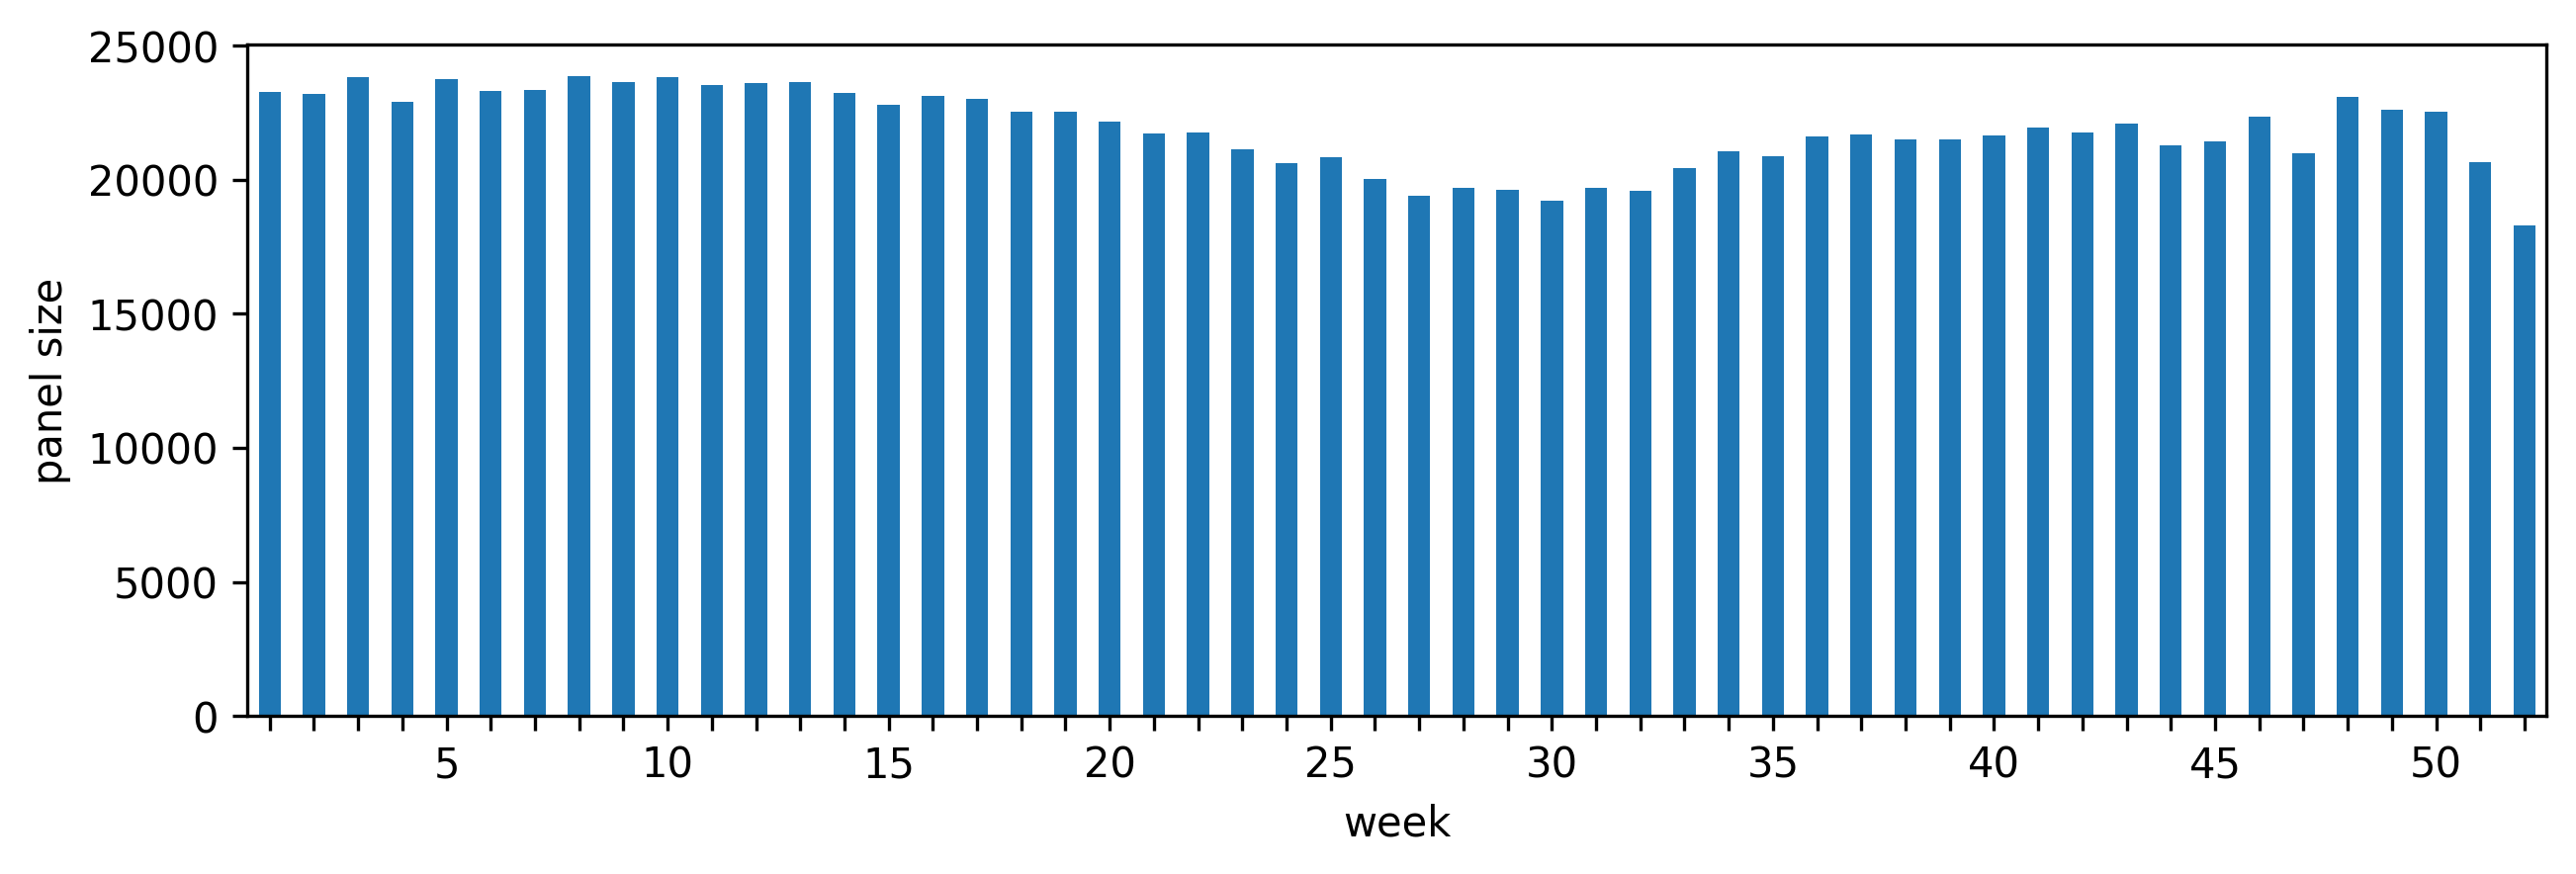

count      520.000000
mean     21875.038462
std       1421.240265
min      18286.000000
25%      20950.250000
50%      21854.000000
75%      23149.000000
max      23856.000000
Name: count, dtype: float64

In [112]:
print('for any given week, panels are the same size')
print('minimum panel size: %s; maximum panel size: %s' % (
    week_panel_id_counts.min(), week_panel_id_counts.max()
))
fig, ax = plt.subplots(1,1, figsize=(10,3), dpi=300)
week_panel_id_counts.to_frame().reset_index().drop_duplicates(
    subset=['week']
).set_index('week')['count'].plot.bar(ax=ax, rot=0) # do not rotate ticks
for i, t in enumerate(ax.get_xticklabels()):
    if ((i % 5) - 4) != 0: t.set_visible(False)
_ = ax.set_ylabel('panel size')
plt.show()
week_panel_id_counts.describe()